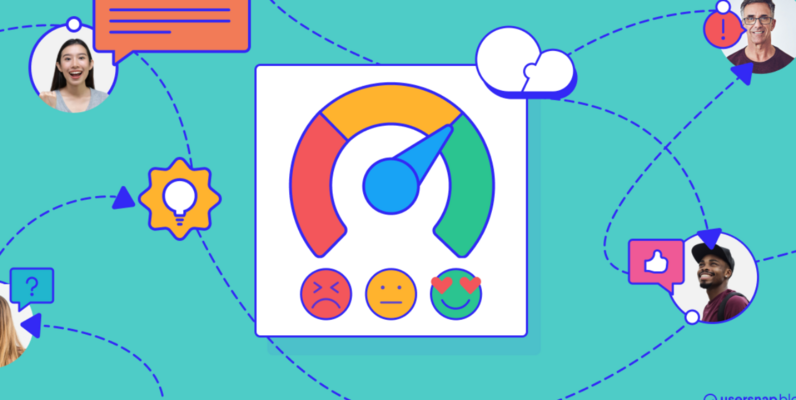

# Sexism Detection in English Texts

Data source: https://www.kaggle.com/datasets/aadyasingh55/sexism-detection-in-english-texts

### Overview (from original source)

This dataset comprises 10,602 English text entries filtered by the label category “none.” It aims to facilitate research in detecting and analyzing sexism in language by providing examples of non-sexist text.

This dataset is valuable for researchers, developers, and organizations interested in developing models for sexism detection in textual data. It can be used to train machine learning algorithms to recognize patterns in non-sexist language and assess biases in text.

### Columns description:

* rewire_id: Unique identifier for each entry.

* text: The English text for analysis.

* label_sexist: Classification indicating whether the text is sexist (not sexist, 75.7%).

* label_category: The category label, which is “none” in this filtered dataset (75.7%).

* label_vector: Represents a vectorization of the text; currently marked as “none” (75.7%).

* split: Indicates the dataset split; all entries belong to the training set (100%).

This notebook is developed by NLP criterias and neural networks including 3 main parts:

#### Part 1 >> Data loading and analysis (Tools: Pandas, Matplotlib, Os)

#### Part 2 >> Data preprocessing (Tools: Re, Nltk, Tensorflow, Numpy)

#### Part 3 >> Modeling and evaluating (Tools: Scikit-learn and Tensorflow)

### Part 1

Data loading and analysis

In [5]:
# Import necessary libraries
import matplotlib.pyplot as plt
import pandas as pd
import re
import numpy as np
import os
from nltk.corpus import stopwords
from sklearn.metrics import confusion_matrix , ConfusionMatrixDisplay
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding , GlobalMaxPooling1D , Dense
from tensorflow.keras.models import Sequential

tokenizer = Tokenizer(oov_token='<000U00>') # Instancing from 'Tokenizer' object

In [6]:
print('File content:')
for i in os.listdir(): print(i)

File content:
.ipynb_checkpoints
dataset-cover.png
dev.csv
LINK.txt
Notebook.ipynb
Sexism Detection in English Texts.zip
test (1).csv
train (2).csv


In [7]:
def Read_file(path):
    """
    Reads a CSV file from the specified path and returns a copy of its content.

    Parameters:
    path (str): The file path to the CSV file.

    Returns:
    pandas.DataFrame: A copy of the data from the CSV file.
    """
    # Read the CSV file from the given path
    file = pd.read_csv(path)
    # Return a copy of the DataFrame to ensure immutability
    return file.copy()

In [8]:
# Load the train csv file
df_train = Read_file('train (2).csv')
df_train = df_train[['text','label_sexist']]
df_train.sample(5)

,text,label_sexist
321,Rachael Chandler Has Taken DOWN her Instagram ...,not sexist
7672,The blood tests came back negative so I wouldn...,not sexist
10595,Men and women are both important. This is cope,not sexist
6178,"You’re missing their point: In THEIR country, ...",not sexist
404,Grow some balls and leave ur girl. Wth a fake ...,not sexist


In [9]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14000 entries, 0 to 13999
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   text          14000 non-null  object
 1   label_sexist  14000 non-null  object
dtypes: object(2)
memory usage: 218.9+ KB


In [10]:
# Find sum of null values in train set
df_train.isnull().sum()

text            0
label_sexist    0
dtype: int64

In [11]:
# Find sum of duplicated values in train set
df_train.duplicated().sum()

0

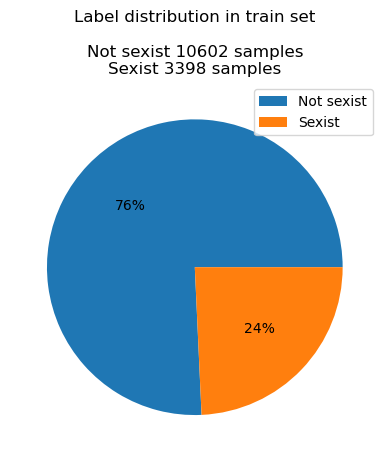

In [12]:
slices = df_train.label_sexist.value_counts().values
plt.pie(slices,autopct='%2.f%%')
plt.legend(['Not sexist','Sexist'])
plt.title(f'Label distribution in train set\n\nNot sexist {slices[0]} samples\nSexist {slices[1]} samples')
plt.show()

In [13]:
# Load the test csv file
df_test = Read_file('test (1).csv')
df_test.sample(5)

,rewire_id,text,label_sexist,label_category,label_vector,split
2642,sexism2022_english-5062,Mexican Store In Jacksonville had a black male...,not sexist,none,none,test
2704,sexism2022_english-5886,do a stone ole stunna on may the hag she has g...,sexist,2. derogation,2.2 aggressive and emotive attacks,test
608,sexism2022_english-8621,"no he is tall arab Chad lite, I have videos of...",not sexist,none,none,test
3612,sexism2022_english-11187,The usually don’t want their daughters to have...,not sexist,none,none,test
1866,sexism2022_english-4780,I'm always in #TwitterJail for pissing off lib...,sexist,2. derogation,2.2 aggressive and emotive attacks,test


In [14]:
df_test = df_test[['text','label_sexist']]

In [15]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   text          4000 non-null   object
 1   label_sexist  4000 non-null   object
dtypes: object(2)
memory usage: 62.6+ KB


In [16]:
# Find sum of null values in test set
df_test.isnull().sum()

text            0
label_sexist    0
dtype: int64

In [17]:
# Find sum of duplicated values in test set
df_test.duplicated().sum()

0

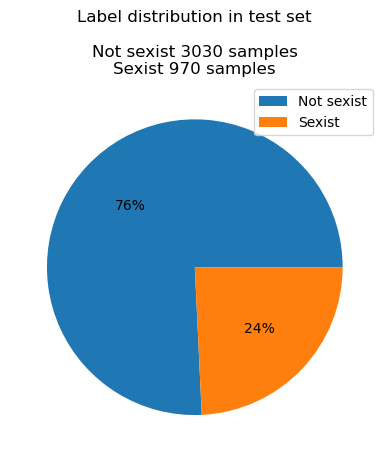

In [18]:
slices = df_test.label_sexist.value_counts().values
plt.pie(slices,autopct='%2.f%%')
plt.legend(['Not sexist','Sexist'])
plt.title(f'Label distribution in test set\n\nNot sexist {slices[0]} samples\nSexist {slices[1]} samples')
plt.show()

### Part 2

Data preprocessing

In [19]:
# List of stop words in English, used for text preprocessing
stop_words = stopwords.words('English')

def remove_emojis(text):
    """
    Removes all emojis from a given text string.

    Parameters:
    text (str): The input string from which emojis need to be removed.

    Returns:
    str: The text with emojis removed.
    """
    # Define a regex pattern for matching various emoji ranges
    emoji_pattern = re.compile(
        "["
        "\U0001F600-\U0001F64F"  # Emoticons
        "\U0001F300-\U0001F5FF"  # Symbols & Pictographs
        "\U0001F680-\U0001F6FF"  # Transport & Map Symbols
        "\U0001F700-\U0001F77F"  # Alchemical Symbols
        "\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
        "\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
        "\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
        "\U0001FA00-\U0001FA6F"  # Chess Symbols
        "\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
        "\U00002702-\U000027B0"  # Dingbats
        "\U000024C2-\U0001F251"  # Enclosed Characters
        "]+", flags=re.UNICODE)
    # Replace emojis in the input text with an empty string
    return emoji_pattern.sub(r'', text)

def Remove_stop_words(list_of_texts) -> list:
    """
    Removes stop words and emojis from a list of text strings.

    Parameters:
    list_of_texts (list): A list of text strings to process.

    Returns:
    list: A list of text strings with stop words and emojis removed.
    """
    # Initialize an empty list to store processed texts
    result = list()
    for text in list_of_texts:
        # Remove stop words from the text
        temp = [word for word in text.split() if word not in stop_words]
        # Join the words back into a single string
        temp = ' '.join(temp)
        # Remove emojis from the processed text and append to the result
        result.append(remove_emojis(temp))
    return result

In [20]:
new_texts = Remove_stop_words(df_train.text) # Remove stop words and emojis from train set texts 
new_texts_test = Remove_stop_words(df_test.text) # Remove stop words and emojis from test set texts 

In [21]:
# Encoding labels in train and test sets to 0 and 1
label_dict = {'not sexist':0,'sexist':1}
labels = np.array([label_dict[l] for l in df_train.label_sexist],dtype='int64')
labels_test = np.array([label_dict[l] for l in df_test.label_sexist],dtype='int64')

In [22]:
tokenizer.fit_on_texts(new_texts) # Tokenizing train set texts
sequences = tokenizer.texts_to_sequences(new_texts) # Make sequences from tokenized words
Maxlen = 50
train = pad_sequences(sequences,padding='post',truncating='post',maxlen=Maxlen) # Make a matrix from sequences

In [23]:
train.shape

(14000, 50)

### Part 3

Modeling and evaluating

In [24]:
# Create a Sequential Embedding neural network
model = Sequential([Embedding(len(tokenizer.index_word)+1,4),
                    GlobalMaxPooling1D(),
                    Dense(1,activation='sigmoid')])

# Compile the model
model.compile(optimizer = 'rmsprop',
              loss= 'binary_crossentropy',
              metrics = ['accuracy'])

In [25]:
# Data train with 30 epochs
history = model.fit(train,labels,epochs=30)

Epoch 1/30
438/438 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7516 - loss: 0.5777
Epoch 2/30
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7633 - loss: 0.5234
Epoch 3/30
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7869 - loss: 0.4952
Epoch 4/30
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7852 - loss: 0.4751
Epoch 5/30
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7937 - loss: 0.4599
Epoch 6/30
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8066 - loss: 0.4422
Epoch 7/30
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8005 - loss: 0.4490
Epoch 8/30
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8065 - loss: 0.4388
Epoch 9/30
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8057 - loss: 0.4358
Epoch 10/30
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8109 - loss: 0.4244
Epoch 11/30
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8152 - loss: 0.4212
Epoch 12/30
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

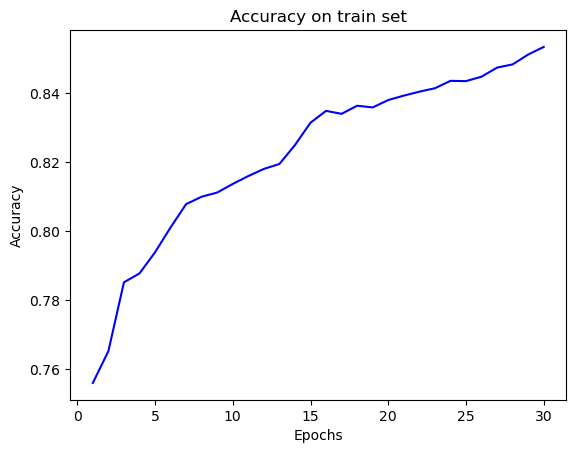

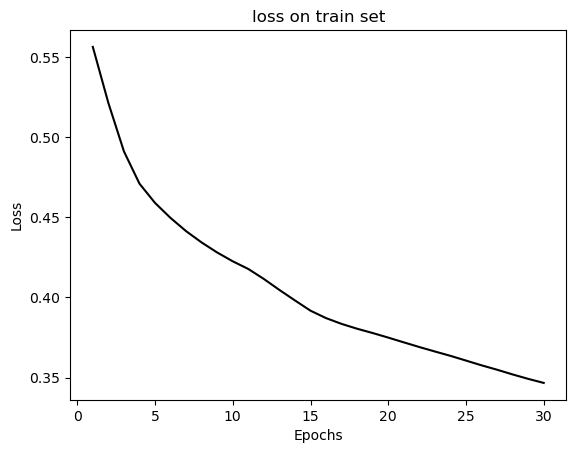

In [26]:
# Plot the results to visualize performance metrics or data distribution
epoch = range(1,len(history.epoch)+1)
results = history.history
plt.plot(epoch,results['accuracy'],'blue')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy on train set')
plt.show()
plt.plot(epoch,results['loss'],'black')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('loss on train set')
plt.show()

In [27]:
# Test data preprocessing
seqeunces_test = tokenizer.texts_to_sequences(new_texts_test) # Make sequences from test set texts
test = pad_sequences(seqeunces_test,padding='post',truncating='post',maxlen=Maxlen) # Make a matrix from sequences

In [28]:
test.shape

(4000, 50)

In [29]:
# Model evaluation on test set
ev = model.evaluate(test,labels_test)
print(f'Accuracy on test set: {ev[1]*100:0.1f}%\nLoss on test set: {ev[0]:0.2f}')

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8332 - loss: 0.4265
Accuracy on test set: 84.4%
Loss on test set: 0.40


Data preprcessing for confusion matrix

In [30]:
pred = model.predict(test) # Predict the test set
# Since the model predicts probability of a sample,
# So Convert them to 0 (Less than 0.5) and 1 (Equal or greater than 0.5)
new_pred = list()
for p in pred.ravel():
    if p<0.5: new_pred.append(0)
    else : new_pred.append(1)

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


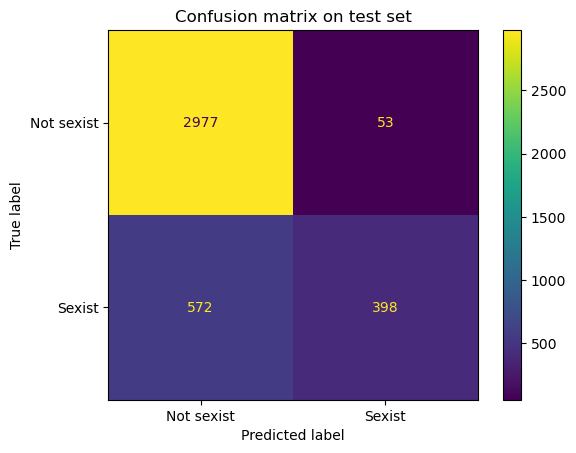

In [31]:
# Create and plot a confusion matrix
con = confusion_matrix(labels_test,new_pred)
display = ConfusionMatrixDisplay(con,display_labels=['Not sexist','Sexist'])
display.plot()
plt.title('Confusion matrix on test set')
plt.show()

# End